# Reference Solution for Coding Assignment "Graph Learning"

## 1. Preparation

### 1.1 Libraries

In [1]:
import numpy as np 
import pandas as pd 
from datetime import datetime
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture

# We will use networx objects to store empircial graphs, local datasets and models
import networkx as nx 
from sklearn.neighbors import kneighbors_graph
from numpy import linalg as LA

### 1.2 Helper functions

In [2]:
# The function generates a scatter plot of nodes (=FMI stations) using 
# latitude and longitude as coordinates. 
def plotFMI(G_FMI):
    
    # Get the coordinates of the stations.
    coords = np.array([G_FMI.nodes[node]['coord'] for node in G_FMI.nodes])
    
    # Draw nodes
    for node in G_FMI.nodes:
        plt.scatter(coords[node,1], coords[node,0], color='black', s=4, zorder=5)  # zorder ensures nodes are on top of edges
        plt.text(coords[node,1]+0.1, coords[node,0]+0.2, str(node), fontsize=8, ha='center', va='center', color='black', fontweight='bold')
    # Draw edges
    for edge in G_FMI.edges:
        plt.plot([coords[edge[0],1],coords[edge[1],1]], [coords[edge[0],0],coords[edge[1],0]], linestyle='-', color='gray', alpha=0.5)

    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.title('FMI stations')
    plt.show()

# The function below extracts a feature and label from each row 
# of dataframe df. Each row is expected to hold a FMI weather 
# measurement with cols "Latitude", "Longitude", "temp", "Timestamp". 
# Returns numpy arrays X, y.
def ExtractFeatureMatrixLabelVector(data):
    nrfeatures = 7 
    nrdatapoints = len(data)
    
    # We build the feature matrix X (each of its rows hold the features of a data point) 
    # and the label vector y (whose entries hold the labels of data points).
    X = np.zeros((nrdatapoints, nrfeatures))
    y = np.zeros((nrdatapoints, 1))

    # Iterate over all rows in dataframe and create corresponding feature vector and label. 
    for ind in range(nrdatapoints):
        # Latitude of FMI station, normalized by 100. 
        lat = float(data['Latitude'].iloc[ind])/100
        # Longitude of FMI station, normalized by 100.
        lon = float(data['Longitude'].iloc[ind])/100
        # Temperature value of the data point.
        tmp = data['temp'].iloc[ind]
        # Read the date and time of the temperature measurement. 
        date_object = datetime.strptime(data['Timestamp'].iloc[ind], '%Y-%m-%d %H:%M:%S')
        # Extract year, month, day, hour, and minute. Normalize these values 
        # to ensure that the features are in range [0,1].
        year = float(date_object.year)/2025
        month = float(date_object.month)/13
        day = float(date_object.day)/32
        hour = float(date_object.hour)/25
        minute = float(date_object.minute)/61
        
        # Store the data point's features and a label.
        X[ind,:] = [lat, lon, year, month, day, hour, minute]
        y[ind,:] = tmp

    return X, y

## 2. Data

### 2.1 Dataset

In [3]:
# Import the weather measurements.
data = pd.read_csv('Assignment_MLBasicsData.csv')

# We consider each temperature measurement (=a row in dataframe) as a 
# separate data point.
# Get the numbers of data points and the unique stations.
num_stations = len(data.name.unique())
num_datapoints = len(data)

### 2.2 Features and labels

In [4]:
# We next build the feature matrix X (each of its rows hold the features of a data point) 
# and the label vector y (whose entries hold the labels of data points).
X, y = ExtractFeatureMatrixLabelVector(data)

print(f"The created feature matrix contains {np.shape(X)[0]} entries of {np.shape(X)[1]} features each.")
print(f"The created label vector contains {np.shape(y)[0]} measurements.")

The created feature matrix contains 19768 entries of 7 features each.
The created label vector contains 19768 measurements.


### 2.3 Empirical graph

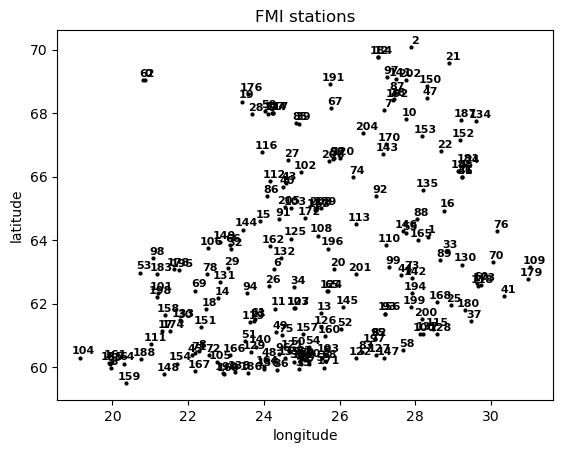

In [5]:
# Create a networkX graph
G_FMI = nx.Graph()

# Add a one node per station
G_FMI.add_nodes_from(range(0, num_stations))

for i, station in enumerate(data.name.unique()):
    # Extract data of a certain station
    station_data = data[data.name==station]
    
    # Extract features and labels
    X_node, y_node = ExtractFeatureMatrixLabelVector(station_data)

    localsamplesize = len(y_node)
    G_FMI.nodes[i]['samplesize'] = localsamplesize # The number of measurements of the i-th weather station
    G_FMI.nodes[i]['name'] = station # The name of the i-th weather station
    G_FMI.nodes[i]['coord'] = np.array([station_data.Latitude.unique()[0], station_data.Longitude.unique()[0]]) # The coordinates of the i-th weather station
    G_FMI.nodes[i]['X'] = X_node # The feature matrix for local dataset at node i
    G_FMI.nodes[i]['y'] = y_node  # The  label vector for local dataset at node i
    G_FMI.nodes[i]['z'] = None # The representation vector for local dataset at node i

# Visualize the empirical graph.
plotFMI(G_FMI)

## 3. The discrepancy measure

### 3.1 Helper function

In [6]:
def add_edges(graph_FMI, node_degree):
    graph = graph_FMI.copy()
    
    for node in graph.nodes:
            
        z_node = graph.nodes[node]['z']
        
        # Create storages for discrepancies and the corresponding neighbors.
        d_mins = np.full(shape=node_degree, fill_value=1e10)
        edges = np.full(shape=(node_degree, 2), fill_value=(node, -1))
    
        for potential_neighbor in graph.nodes:
            if potential_neighbor != node:
                z_neighbor = graph.nodes[potential_neighbor]['z']
                d = LA.norm(z_node - z_neighbor)

                # Find the max discrepancy so far.
                d_max_idx = np.argmax(d_mins)
                d_max = d_mins[d_max_idx]
                
                if d < d_max:
                    d_mins[d_max_idx] = d
                    edges[d_max_idx][1] = potential_neighbor

        # print(f"Node {node} has neighbors {[edges[neighbor][1] for neighbor in range(node_degree)]}")
        graph.add_edges_from(edges) 

    return graph

### 3.2 Student task #1 - The average temperature 

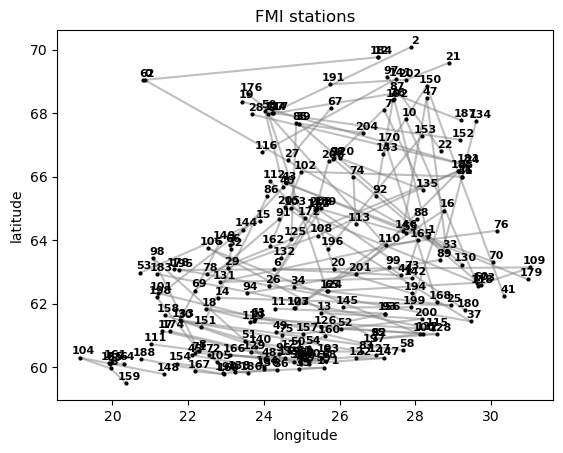

In [7]:
def add_edges_avg_temp(graph_FMI, n_neighbors): 
    # Copy the nodes to a new graph.
    graph = graph_FMI.copy()

    # Create the representation vector for each node.
    for node in graph.nodes:
        avg_temp = np.mean(graph.nodes[node]['y'])
        graph.nodes[node]['z'] = avg_temp

    # Add edges.
    graph = add_edges(graph, n_neighbors)
    
    return graph

# Visualize an example graph. 
plotFMI(add_edges_avg_temp(G_FMI, 1))

### 3.3 Student task #2 - The difference in GMM parameters

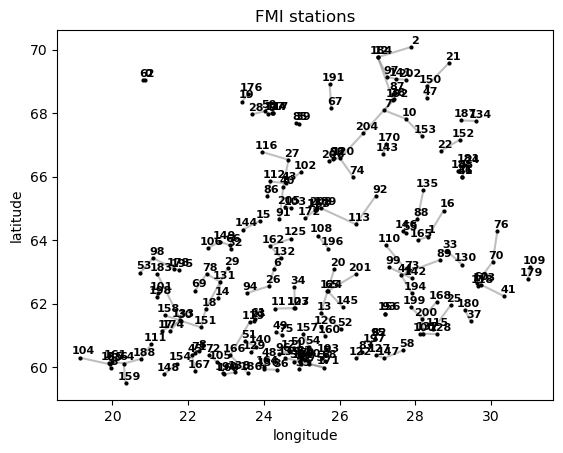

In [8]:
def add_edges_GMM_param(graph_FMI, GMM_seed, n_neighbors):
    # Copy the nodes to a new graph.
    graph = graph_FMI.copy()

    # Define the number components for the GMM. 
    n_components = 2

    # Fit the nodes to the GMM model and extract the model's parameters.
    for node in graph.nodes():

        # Extract node's features.
        node_X = graph.nodes[node]['X']

        # Fit GMM.
        gmm = GaussianMixture(n_components=n_components, random_state = GMM_seed) 
        gmm.fit(node_X)

        # Get the parameters of the GMM (mean vectors, covariance matricies, and component weights).
        gmm_params = np.concatenate((np.concatenate((gmm.means_.ravel(), gmm.covariances_.ravel())), gmm.weights_))

        # Assign GMM parameters to the node.
        graph.nodes[node]['z'] = gmm_params

    # Add edges.
    graph = add_edges(graph, n_neighbors)

    return graph

# Visualize an example graph. 
plotFMI(add_edges_GMM_param(G_FMI, 4740, 1))

### 3.4 Student task #3 - The gradient of the average squared error loss

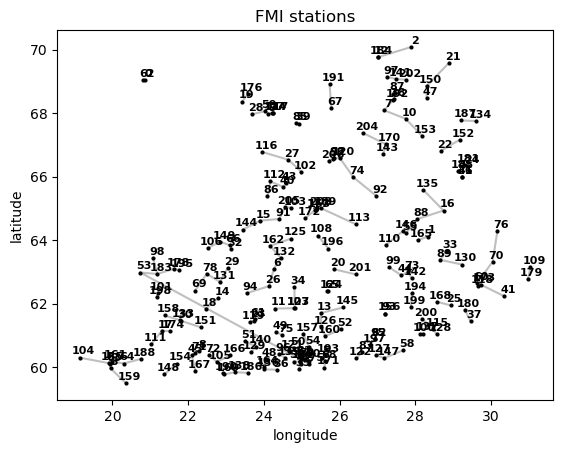

In [9]:
def add_edges_gradient_loss(graph_FMI, n_neighbors):
    # Copy the nodes to a new graph.
    graph = graph_FMI.copy()

    # Define and fit the Linear regression.
    linear_reg = LinearRegression()
    linear_reg.fit(X, y)

    # Extract the weight vector.
    w_hat = linear_reg.coef_

    # Calculate the average squared error loss.
    for node in graph.nodes:
        node_X = graph.nodes[node]['X']
        node_y = graph.nodes[node]['y']
        m = graph.nodes[node]['samplesize']
        loss = (-2/m) * node_X.T.dot(node_y - node_X.dot(w_hat.T))
        graph.nodes[node]['z'] = loss

    # Add edges.
    graph = add_edges(graph, n_neighbors)

    return graph

# Visualize an example graph. 
plotFMI(add_edges_gradient_loss(G_FMI, 1))

## 4. Model

### 4.1 FedGD

In [10]:
def FedGD(graph_FMI, split_seed):
    graph = graph_FMI.copy()
    
    for node in graph.nodes:
        # Split the dataset into training and validation set. 
        X_train, X_val, y_train, y_val = train_test_split(graph.nodes[node]['X'], graph.nodes[node]['y'], test_size=0.2, random_state=split_seed)
        
        graph.nodes[node]['X_train'] = X_train # The training feature matrix for local dataset at node i
        graph.nodes[node]['y_train'] = y_train  # The training label vector for local dataset at node i
        graph.nodes[node]['X_val'] = X_val # The training feature matrix for local dataset at node i
        graph.nodes[node]['y_val'] = y_val  # The training label vector for local dataset at node i
    
    # Initialize all weight vectors with zeros 
    for station in graph.nodes:
        graph.nodes[station]['weights'] = np.zeros((7, 1))
    
    # Define hyperparameters.
    max_iter = 1000
    alpha = 0.5
    l_rate = 0.1
    num_stations = len(graph.nodes)
    
    for i in range(max_iter):
        # Iterate over all nodes.
        for current_node in graph.nodes:
             
            # Extract the training data from the current node.
            X_train = graph.nodes[current_node]['X_train']
            y_train = graph.nodes[current_node]['y_train']
            w_current = graph.nodes[current_node]['weights']
            training_size = len(y_train)
            
            # Compute the first term of the Equation 5.9.
            term_1 = (2/training_size) * X_train.T.dot(y_train - X_train.dot(w_current))
            # Compute the second term of the Equation 5.9
            # by receiving neighbors' weight vectors.
            term_2 = 0
            neighbors = list(graph.neighbors(current_node))
            for neighbor in neighbors:
                w_neighbor = graph.nodes[neighbor]['weights']
                term_2 += w_neighbor - w_current
            term_2 *= 2*alpha
            # Equation 5.8
            w_updated = w_current + l_rate * (term_1 + term_2)
            
            # Update the current weight vector but do not overwrite the 
            # "weights" attribute as we need to do all updates synchronously, i.e., 
            # using the previous local params 
            
            graph.nodes[current_node]['newweights'] = w_updated
        
        # after computing the new localparmas for each node, we now update 
        # the node attribute 'weights' for all nodes 
        for node_id in graph.nodes: 
            graph.nodes[node_id]['weights'] = graph.nodes[node_id]['newweights']

    # Create the storages for the training and validation errors.
    train_errors = np.zeros(num_stations)
    val_errors = np.zeros(num_stations)
    
    # Iterate over all nodes.
    for station in graph.nodes:
        # Extract the data of the current node.
        X_train = graph.nodes[station]['X_train']
        y_train = graph.nodes[station]['y_train']
        X_val = graph.nodes[station]['X_val']
        y_val = graph.nodes[station]['y_val']
        w = graph.nodes[station]['weights']
        
        # Compute and store the training and validation errors.
        train_errors[station] = mean_squared_error(y_train, X_train.dot(w))
        val_errors[station] = mean_squared_error(y_val, X_val.dot(w))
        
    # Output the average training and validation errors.
    return np.mean(train_errors), np.mean(val_errors)

### 4.2 Test connectivity

In [13]:
# Define the random seed for
# add_edges_GMM_param function.
seed = 4740

for num_neighbors in range(1, 11):
    G_FMI_1 = add_edges_avg_temp(G_FMI, num_neighbors)
    G_FMI_2 = add_edges_GMM_param(G_FMI, seed, num_neighbors)
    G_FMI_3 = add_edges_gradient_loss(G_FMI, num_neighbors)
    
    # Print the results.
    print(f"The minimum number of neighbors is {num_neighbors}")
    print(f"G_FMI_1 is connected: {nx.is_connected(G_FMI_1)}")
    print(f"G_FMI_2 is connected: {nx.is_connected(G_FMI_2)}")
    print(f"G_FMI_3 is connected: {nx.is_connected(G_FMI_3)}\n")

The minimum number of neighbors is 1
G_FMI_1 is connected: False
G_FMI_2 is connected: False
G_FMI_3 is connected: False

The minimum number of neighbors is 2
G_FMI_1 is connected: False
G_FMI_2 is connected: False
G_FMI_3 is connected: False

The minimum number of neighbors is 3
G_FMI_1 is connected: False
G_FMI_2 is connected: False
G_FMI_3 is connected: False

The minimum number of neighbors is 4
G_FMI_1 is connected: False
G_FMI_2 is connected: False
G_FMI_3 is connected: True

The minimum number of neighbors is 5
G_FMI_1 is connected: True
G_FMI_2 is connected: False
G_FMI_3 is connected: True

The minimum number of neighbors is 6
G_FMI_1 is connected: True
G_FMI_2 is connected: False
G_FMI_3 is connected: True

The minimum number of neighbors is 7
G_FMI_1 is connected: True
G_FMI_2 is connected: False
G_FMI_3 is connected: True

The minimum number of neighbors is 8
G_FMI_1 is connected: True
G_FMI_2 is connected: False
G_FMI_3 is connected: True

The minimum number of neighbors i

### 4.3 FedGD errors

In [14]:
# Define the random seed for
# add_edges_GMM_param and FedGD functions.
seed = 4740

# The minimum number of neighbors to connect with.
num_neighbors = 1

# Add edges.
G_FMI_1 = add_edges_avg_temp(G_FMI, num_neighbors)
G_FMI_2 = add_edges_GMM_param(G_FMI, seed, num_neighbors)
G_FMI_3 = add_edges_gradient_loss(G_FMI, num_neighbors)

# Apply the FedGD algorithm.
G_FMI_1_train_error, G_FMI_1_val_error = FedGD(G_FMI_1, seed)
G_FMI_2_train_error, G_FMI_2_val_error = FedGD(G_FMI_2, seed)
G_FMI_3_train_error, G_FMI_3_val_error = FedGD(G_FMI_3, seed)

# Print the results.
print(f"The seed is {seed}")
print(f"The average training error for G_FMI_1: {G_FMI_1_train_error}\nThe average validation error for G_FMI_1: {G_FMI_1_val_error}\n")
print(f"The average training error for G_FMI_2: {G_FMI_2_train_error}\nThe average validation error for G_FMI_2: {G_FMI_2_val_error}\n")
print(f"The average training error for G_FMI_3: {G_FMI_3_train_error}\nThe average validation error for G_FMI_3: {G_FMI_3_val_error}\n\n")

The seed is 4740
The average training error for G_FMI_1: 20.68635695529578
The average validation error for G_FMI_1: 21.386552008386015

The average training error for G_FMI_2: 20.201786964135945
The average validation error for G_FMI_2: 20.892958171150042

The average training error for G_FMI_3: 20.052132233485334
The average validation error for G_FMI_3: 20.64577295712873


